# Exploratory Data Analysis

In [43]:
import sys
import pandas as pd
sys.path.append("../")
import warnings
warnings.filterwarnings("ignore")
from utils.visualizations import Visualization

# Data

In [44]:
df = pd.read_csv("./Data/Abandono_clientes.csv")
print(f"Shape: {df.shape}")
df.head()

Shape: (10000, 14)


RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         79084.10       0

### Columns like `RowNumber`, `CustomerId` and `Surname` can be dropped, since they wont give us any insight

In [45]:
df = df.drop(columns=["RowNumber", "CustomerId", "Surname"])

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


In [47]:
visualizer = Visualization(df)

# Univariate Analysis

## Numerical Columns

In [48]:
numerical_columns = ["CreditScore", "Age", "Tenure", "Balance", "NumOfProducts", "EstimatedSalary"]
df[numerical_columns].describe()

CreditScore           Age        Tenure        Balance  NumOfProducts  \
count  10000.000000  10000.000000  10000.000000   10000.000000   10000.000000   
mean     650.528800     38.921800      5.012800   76485.889288       1.530200   
std       96.653299     10.487806      2.892174   62397.405202       0.581654   
min      350.000000     18.000000      0.000000       0.000000       1.000000   
25%      584.000000     32.000000      3.000000       0.000000       1.000000   
50%      652.000000     37.000000      5.000000   97198.540000       1.000000   
75%      718.000000     44.000000      7.000000  127644.240000       2.000000   
max      850.000000     92.000000     10.000000  250898.090000       4.000000   

       EstimatedSalary  
count     10000.000000  
mean     100090.239881  
std       57510.492818  
min          11.580000  
25%       51002.110000  
50%      100193.915000  
75%      149388.247500  
max      199992.480000

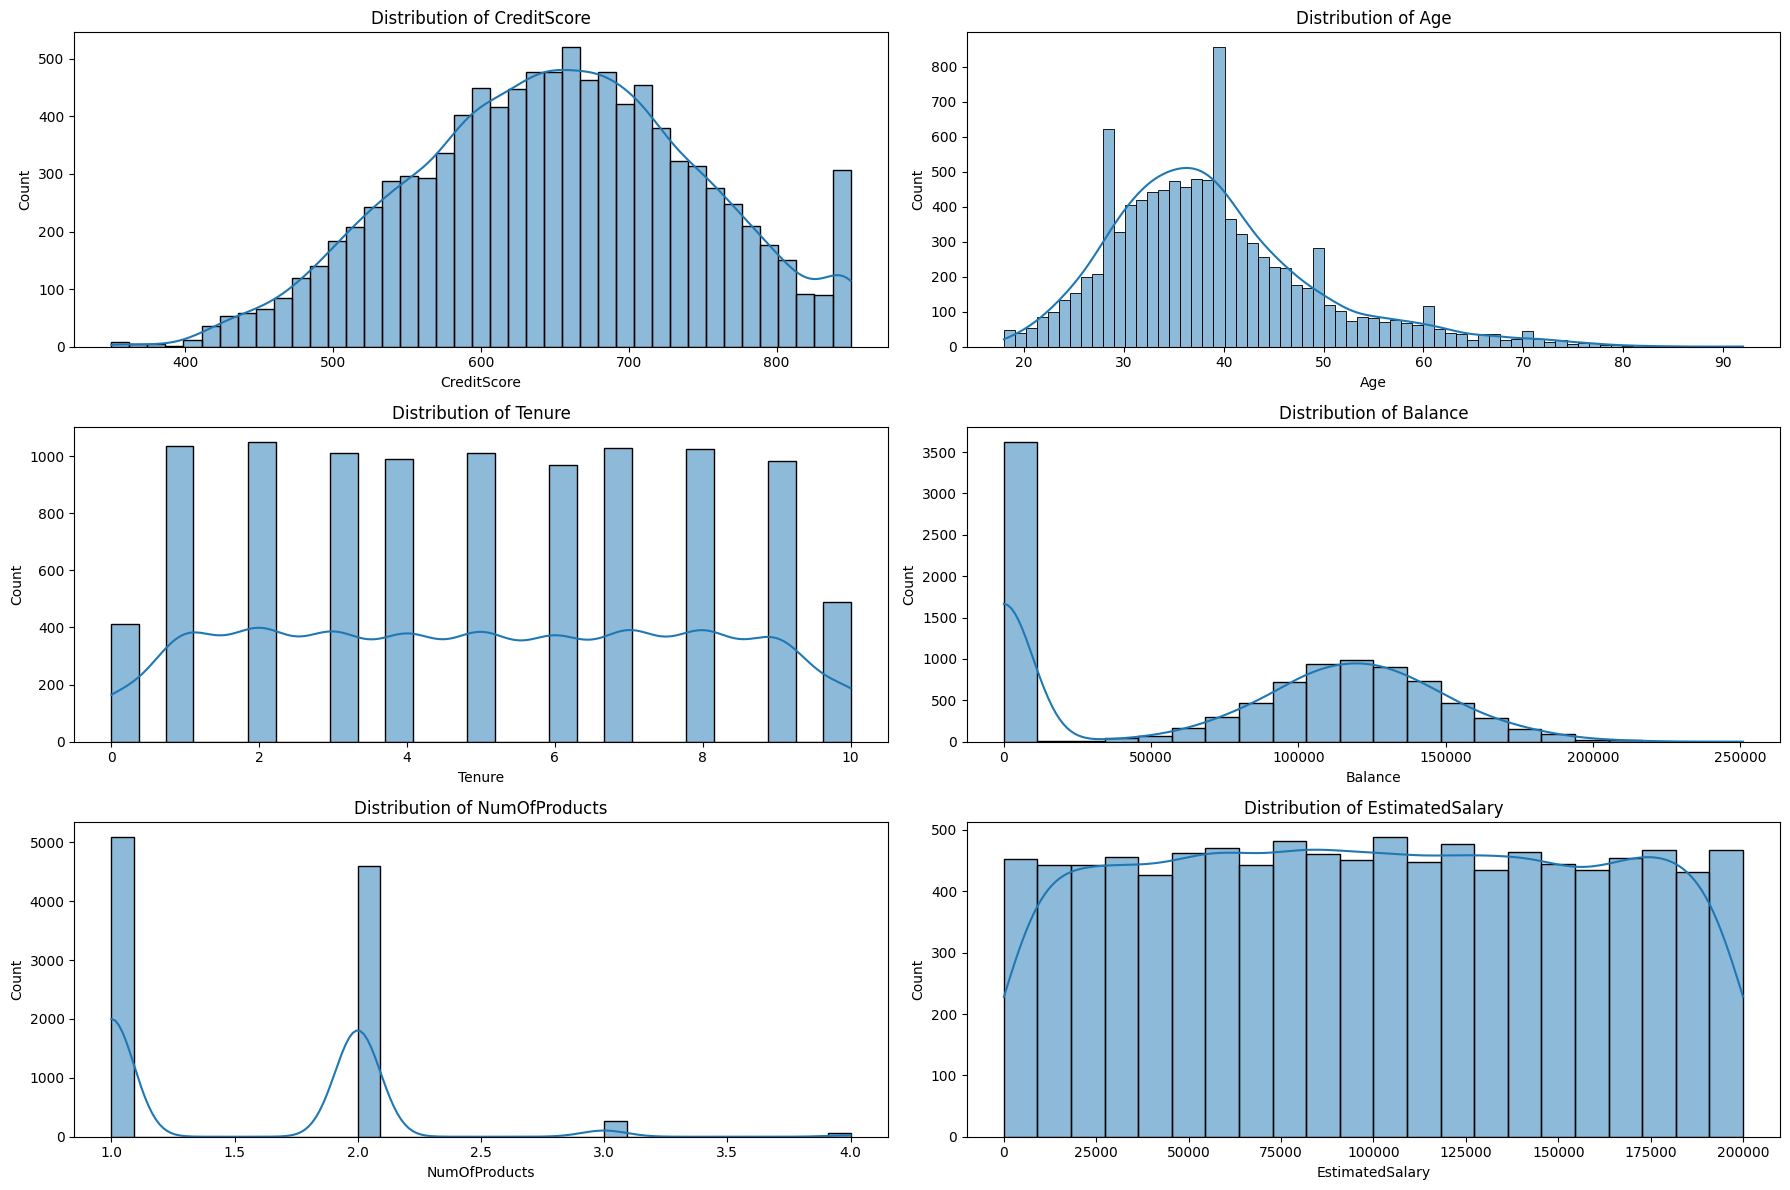

In [49]:
visualizer.num_univariate_analysis(numerical_columns, 3, 2)

In [50]:
for col in df[["Balance", "Exited"]]:
    print(df[col].value_counts(normalize=True).head(3))

Balance
0.00         0.3617
130170.82    0.0002
105473.74    0.0002
Name: proportion, dtype: float64
Exited
0    0.7963
1    0.2037
Name: proportion, dtype: float64


### Observations:
- `Exited` is very unbalanced, with almost 80% of all data concentrated on the 0 class
- `CreditScore`, `Age`, `Tenure` and `EstimatedSalary` all appear to have a distribution close to a normal one
- `Balance` has a negatively skewed distribution, with mean < median < mode. Also, 36% of its values are 0. This can be due to unused accounts or to the fact that these clients simply didn't want to have a balance on this account
- `NumOfProducts` and `Tenure` have discrete values
### Impact:
- In the future, some method of class balancing will be used in order to prevent the models from being extremely biased
- It would be interesting to test some methods to make the distributions of `Balance` more closely resemble a gaussian one
- Since `Balance` has an abnormal number of zeros, it would be interesting to investigate this further to see how this feature behaves regarding the target
- `NumOfProducts` and `Tenure` will be investigated further to check if they will be used as numerical or categorical features
- Scaling the data will be necessary for better results, but the scaler will be chosen after the columns are close to a gaussian distribution

## `NumOfProducts` and `Tenure` analysis

In [51]:
for col in df[["Tenure", "NumOfProducts"]]:
    print(df.groupby(col).agg(Exited_mean=('Exited', 'mean'), Count=('Exited', 'size')).reset_index())

    Tenure  Exited_mean  Count
0        0     0.230024    413
1        1     0.224155   1035
2        2     0.191794   1048
3        3     0.211100   1009
4        4     0.205258    989
5        5     0.206522   1012
6        6     0.202689    967
7        7     0.172179   1028
8        8     0.192195   1025
9        9     0.216463    984
10      10     0.206122    490
   NumOfProducts  Exited_mean  Count
0              1     0.277144   5084
1              2     0.075817   4590
2              3     0.827068    266
3              4     1.000000     60


### Observations:
- `Tenure` has basically the same churn rate for all values and, as seen before, is well-balanced
- `NumOfProducts` is extremely unbalanced and the churn rate per value is non-linear
### Impact:
- `Tenure` can be maintained as a numerical feature, given that's a feature where the values have a meaningful order, since it indicates the amount of time the client is with the institution, and has a uniformed distribution, with the churn rate being almost constant
- `NumOfProducts` will be used as a categorical feature. The values have a natural order, but they don't have a consistent relation with the target. Also, since all clients with 4 products have churned, the percentage for 3 products is very high and there are very few clients with 3 and 4 products, this can create a small bias to the model. To mitigate this, I will combine 3 and 4 products into the same category "3 or more", reducing the potential bias from the perfect correlation of 4 products - 100% chance of churn

In [52]:
numerical_columns.remove("NumOfProducts")

## Categorical Columns

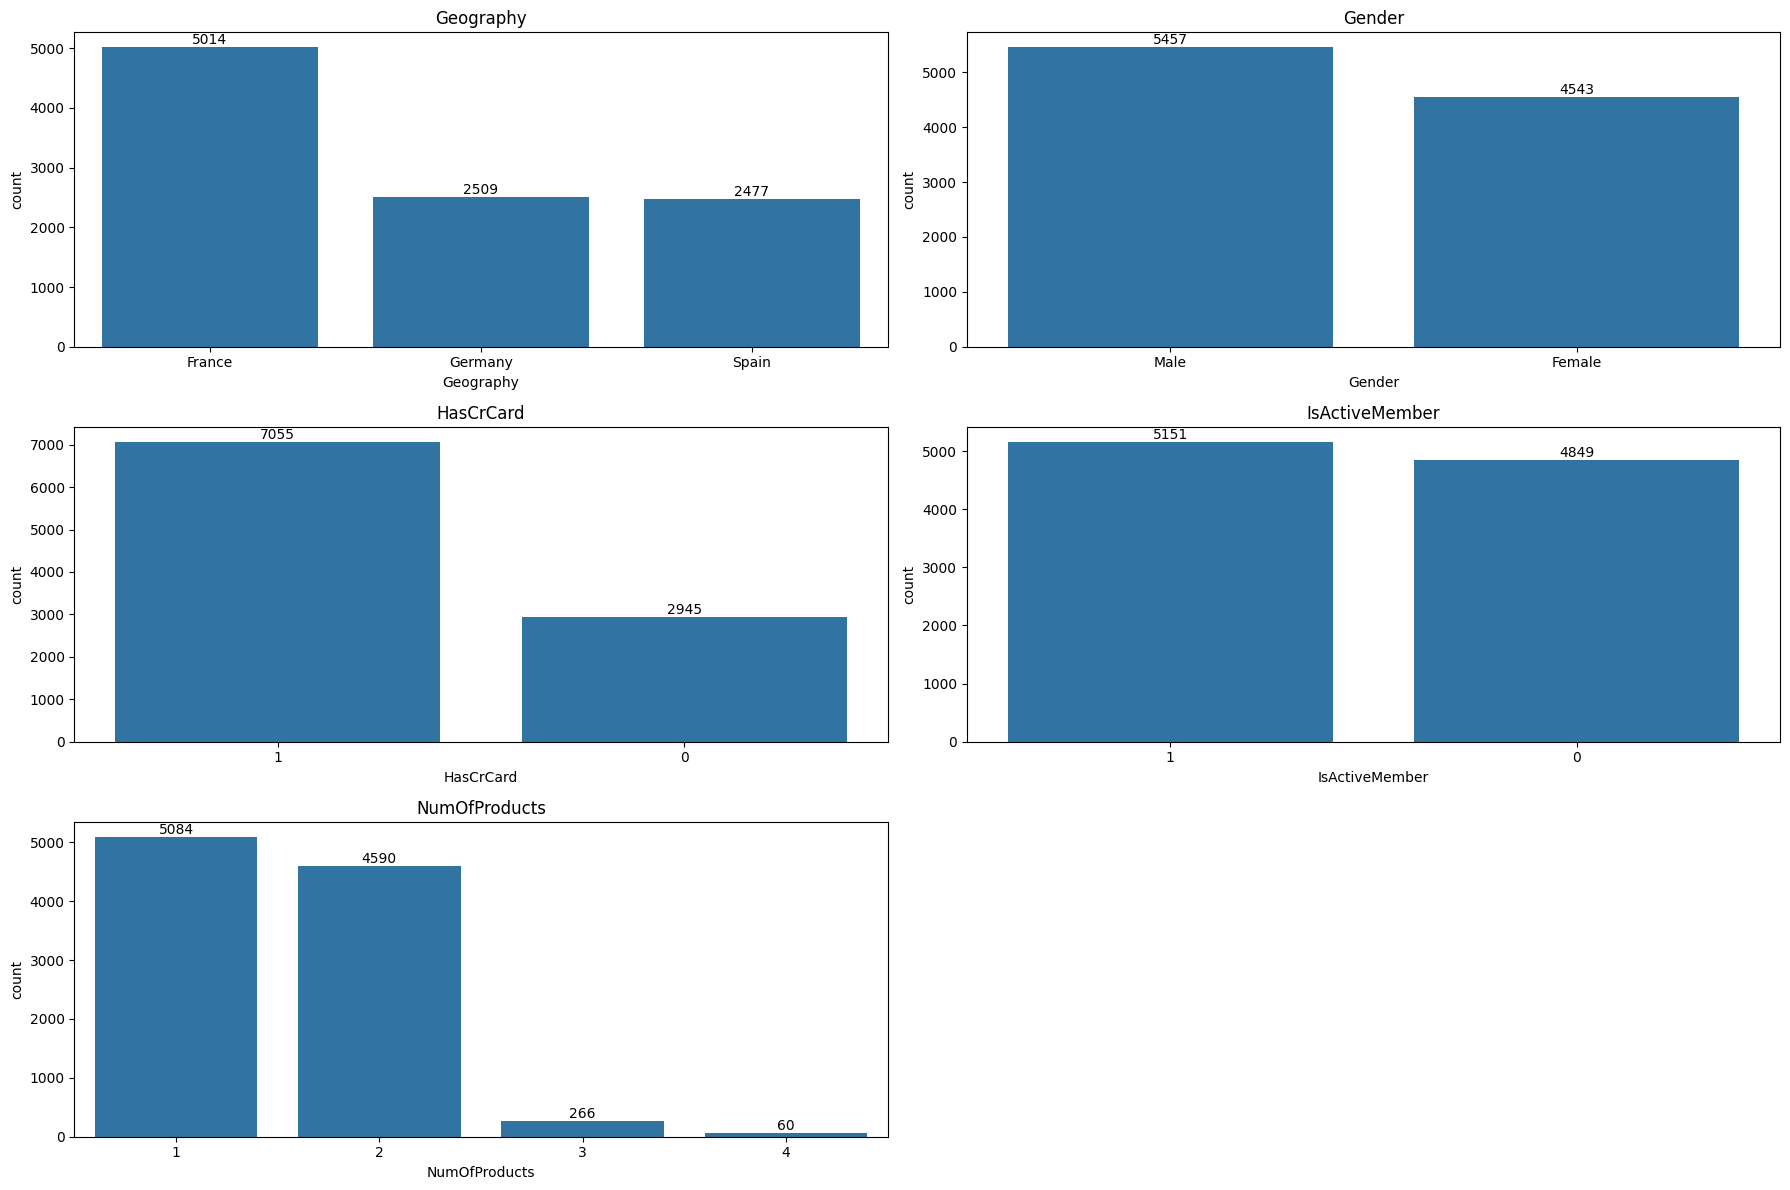

In [53]:
cat_columns = df.select_dtypes(include="object").columns.tolist() + ["HasCrCard", "IsActiveMember", "NumOfProducts"]
visualizer.cat_univariate_analysis(cat_columns, 3, 2)

### Observations:
- Almost half of all clients are from France
- `Gender` is pretty balanced, with only a thousand being the difference between genders
- 70% of all clients have a credit card
- `IsActiveMember` is very balanced, with active clients being only a little bit more prevalent
- 1 and 2 products compose 95% of `NumOfProducts` data

# Features x Target

## Numerical Features

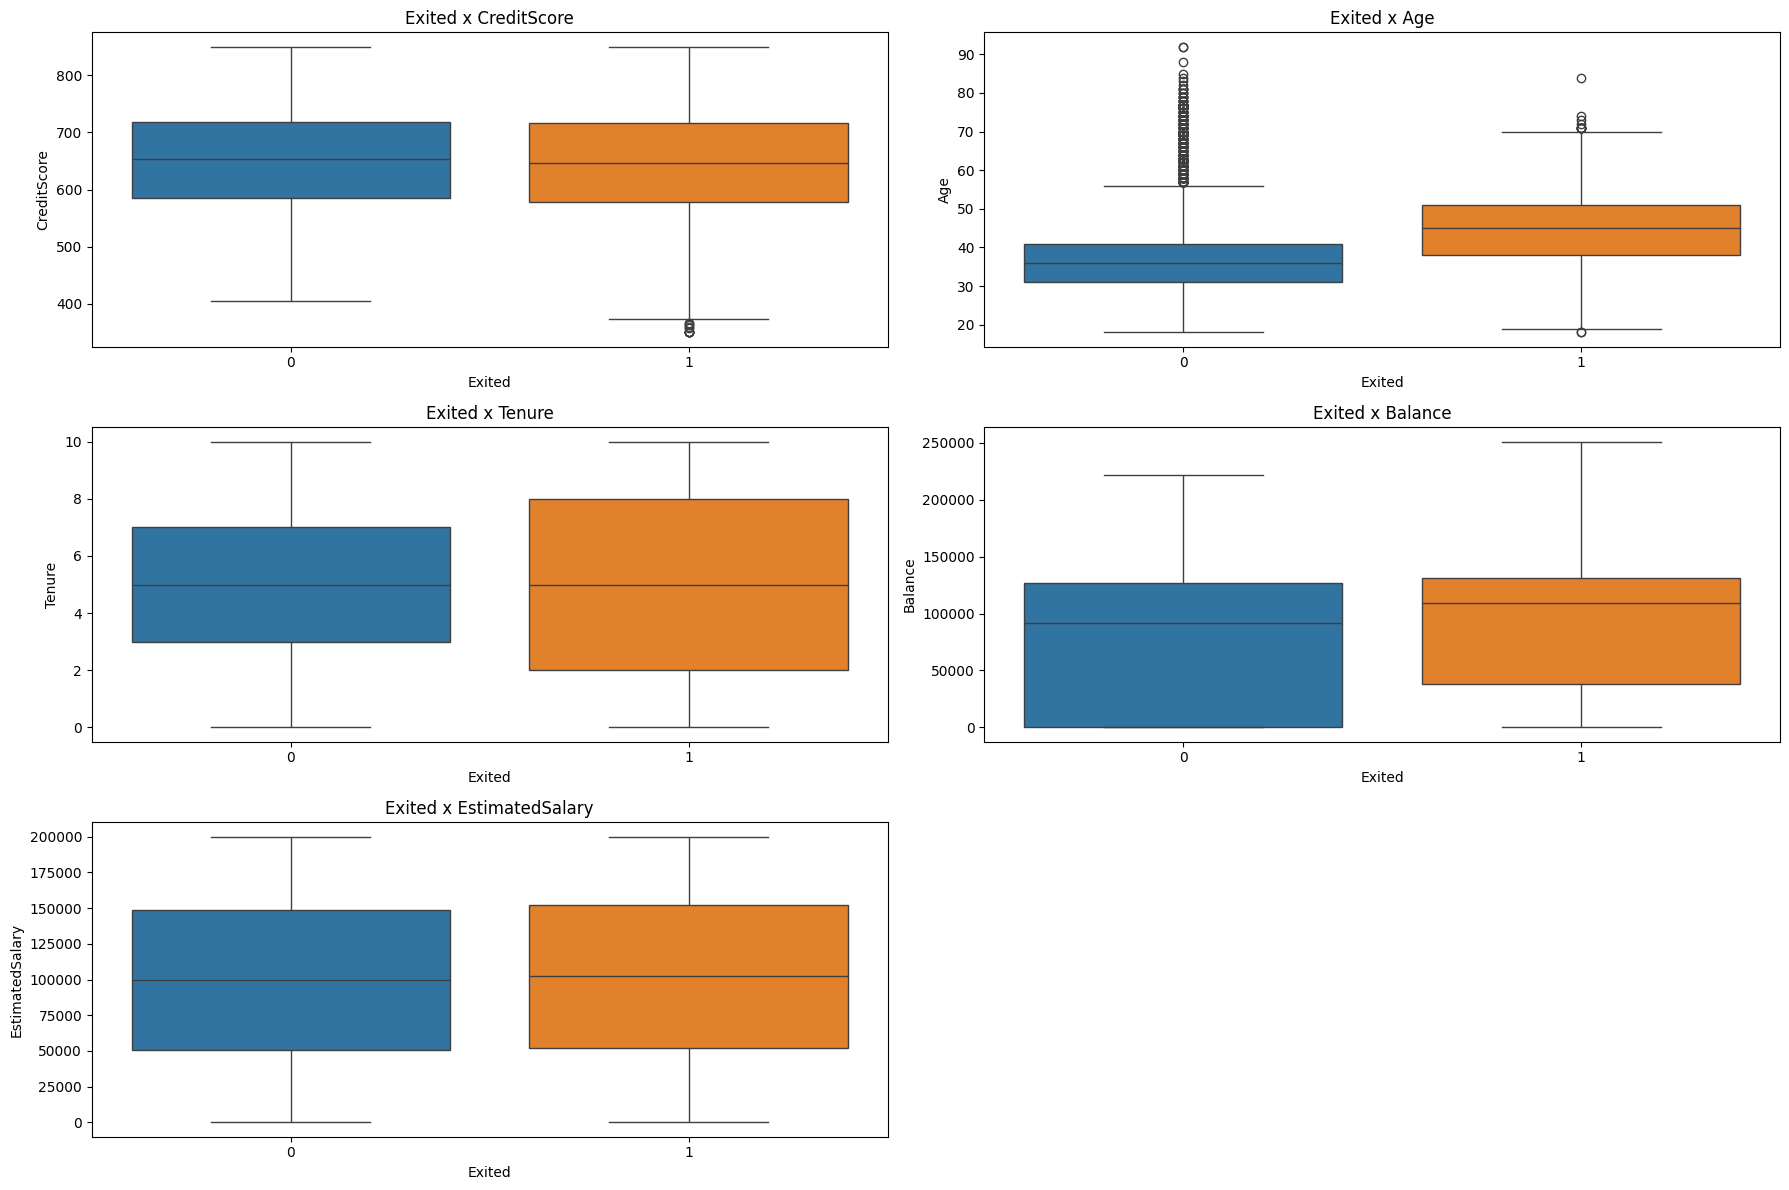

In [54]:
visualizer.num_features_vs_target(3, 2, "Exited", numerical_columns, "boxplot")

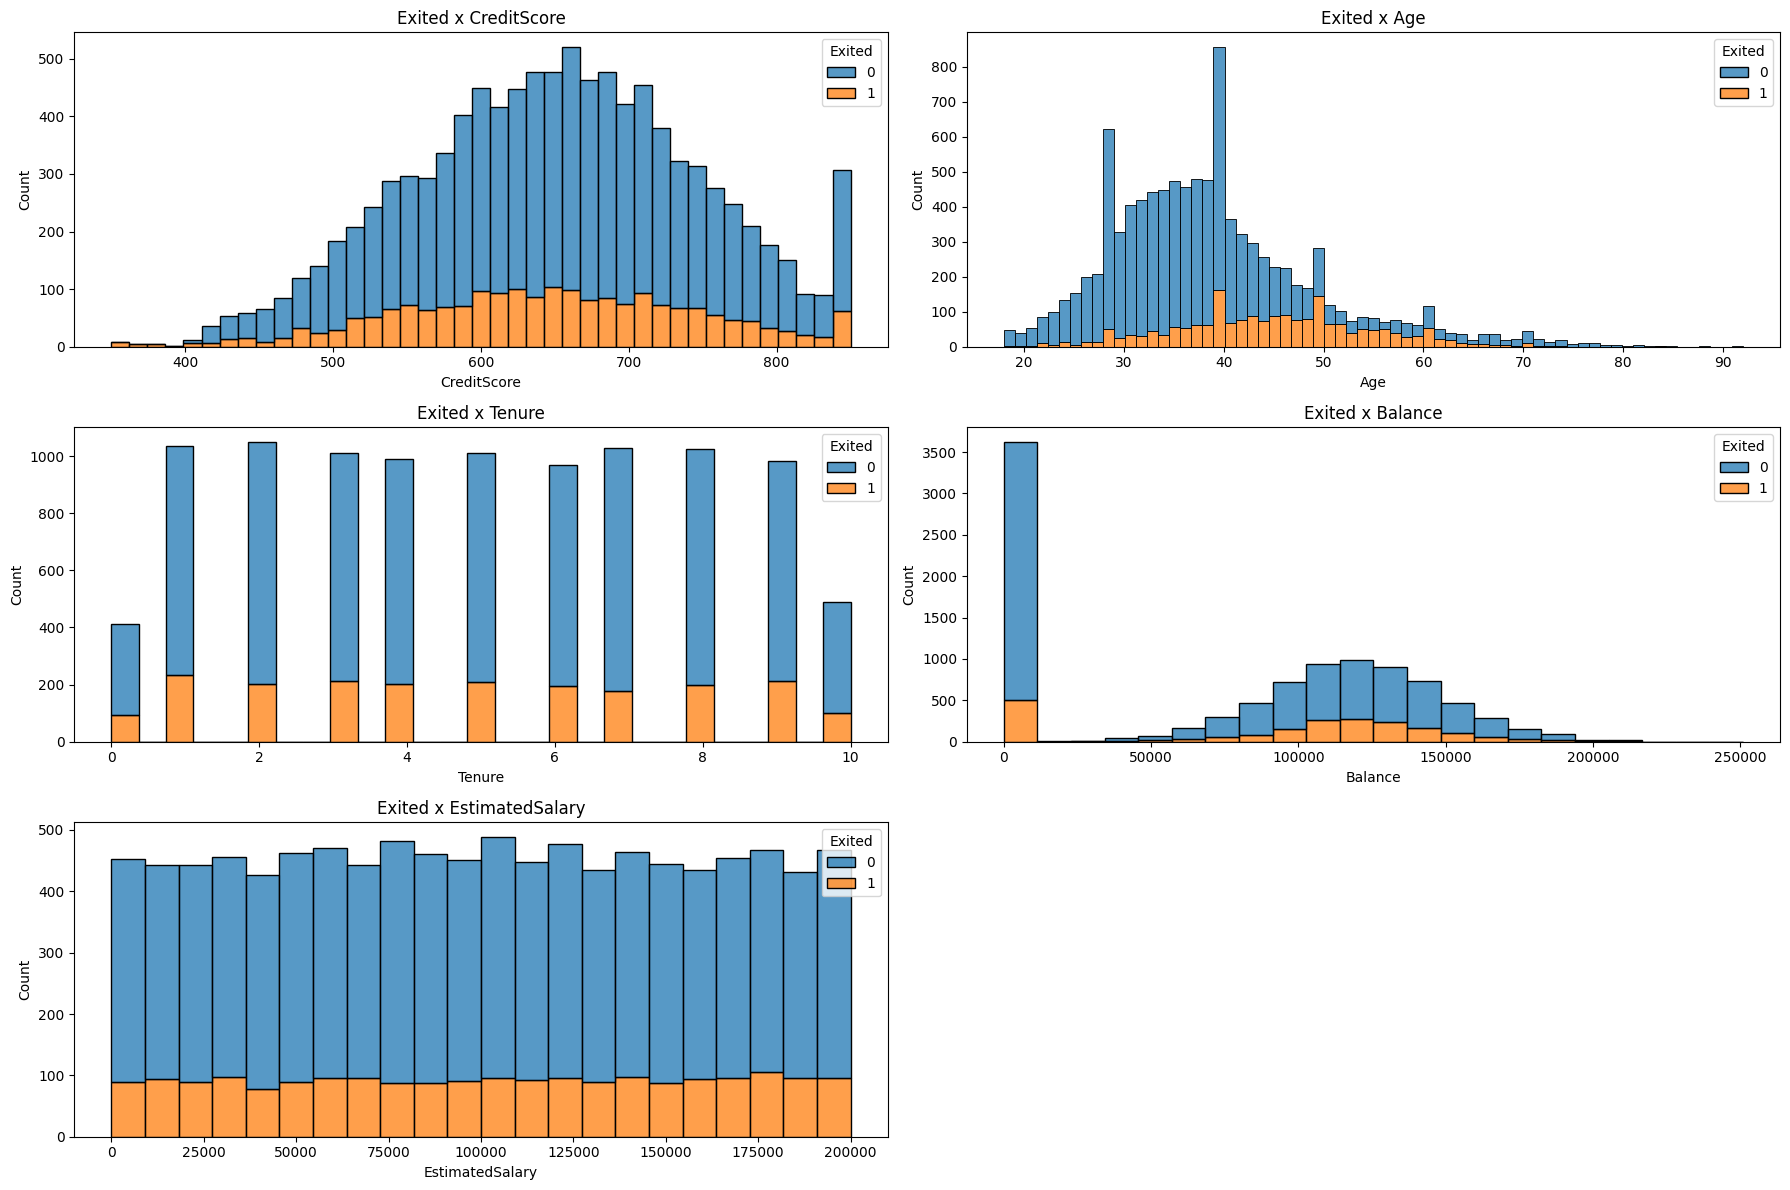

In [55]:
visualizer.num_features_vs_target(3, 2, "Exited", numerical_columns, "histplot")

In [56]:
df.groupby("Balance")["Exited"].mean().reset_index().head(1)

Balance    Exited
0      0.0  0.138236

### Observations:
- `CreditScore`, `Tenure` and `EstimatedSalary` show the same behavior in relation to the target for all values, indicating that these features wouldn't contribute a lot to the model
- `Age` shows that older clients, around 40-50 years old, have a higher churn rate. This can be attributed to a number of things. Maybe they think that the website/app that they use to manage their accounts is too complicated, maybe they are leaving because there are better institutions with better products or services. Either way, this feature appears to be very useful for the model
- The histogram of `Balanced` shows that all values have the same behavior in relation to the target, but we can see from the boxplot that actually, clients with a higher balance in their accounts have a small, but higher churn rate
- From all clients with no balance, 13% of them have churned

## Categorical Features

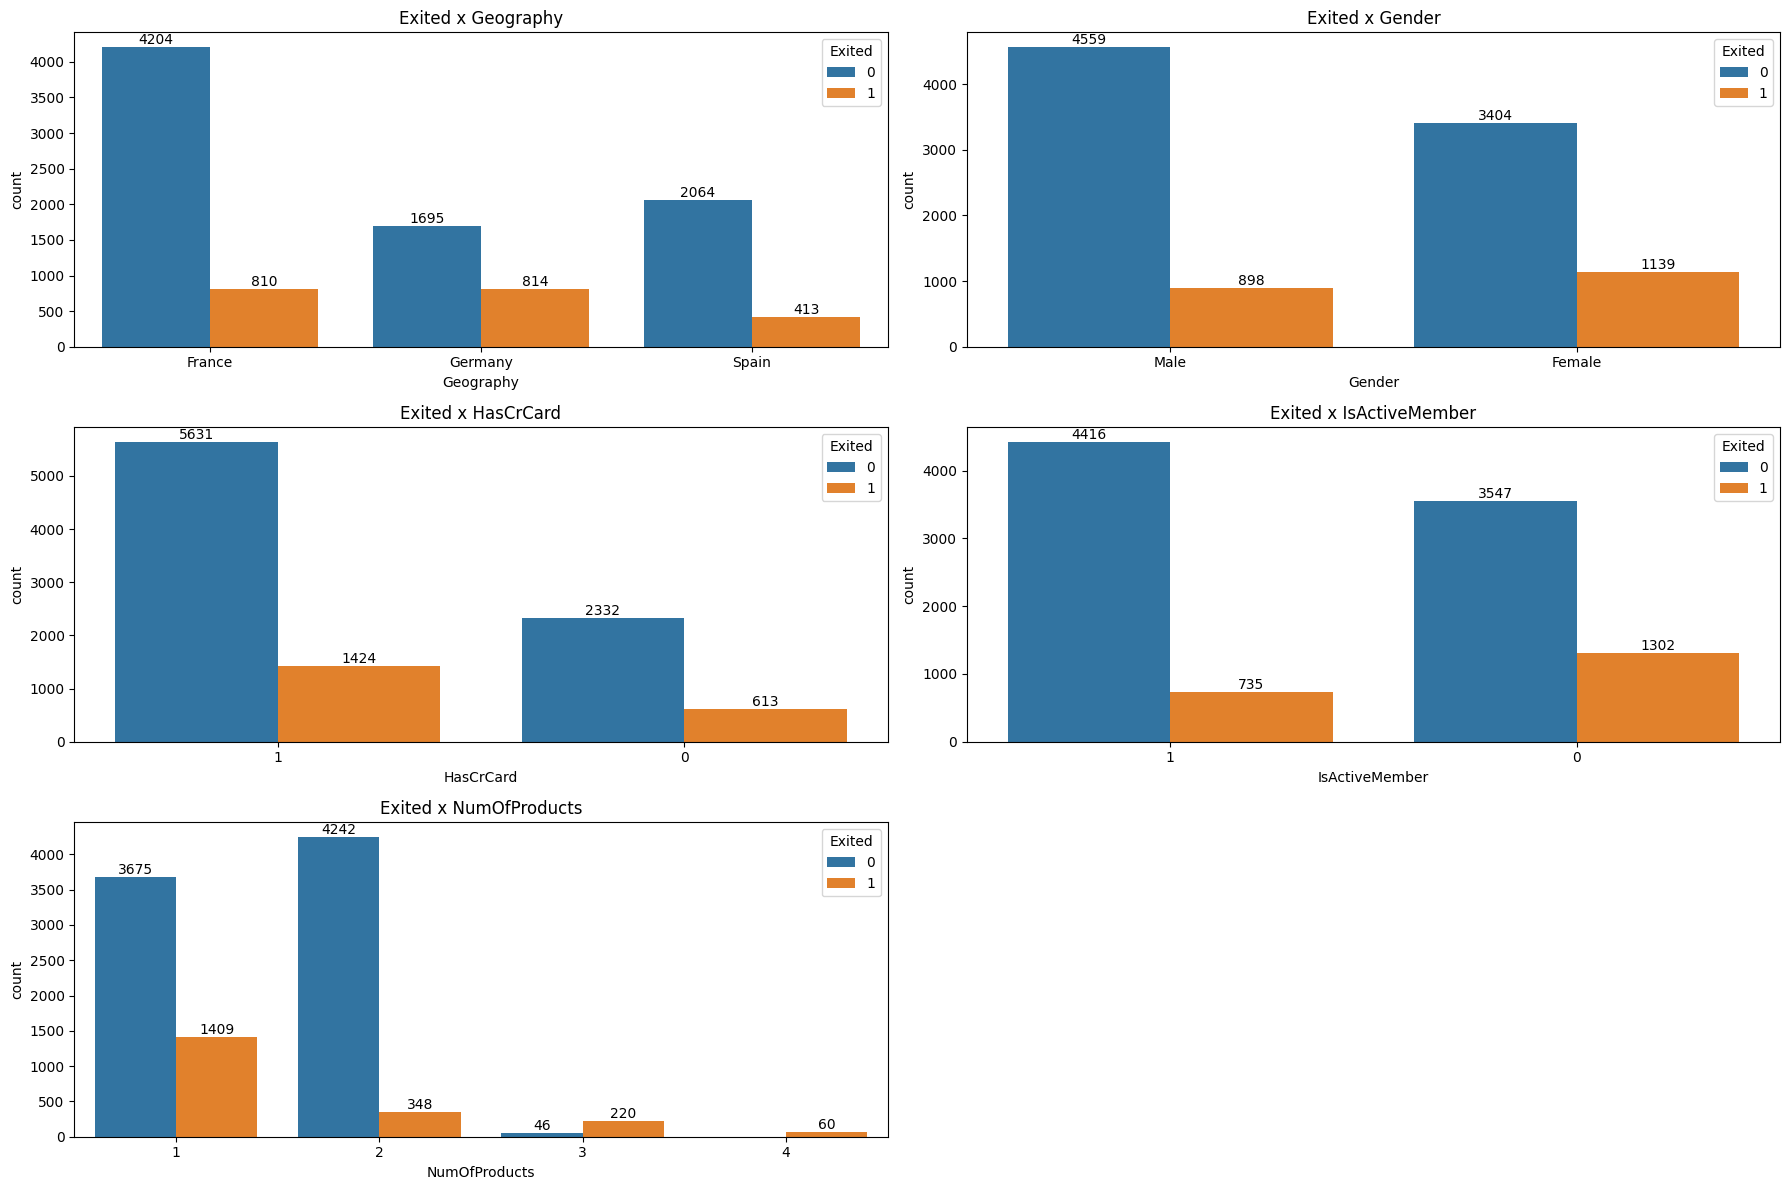

In [57]:
visualizer.cat_features_vs_target(3, 2, "Exited", cat_columns, "countplot")

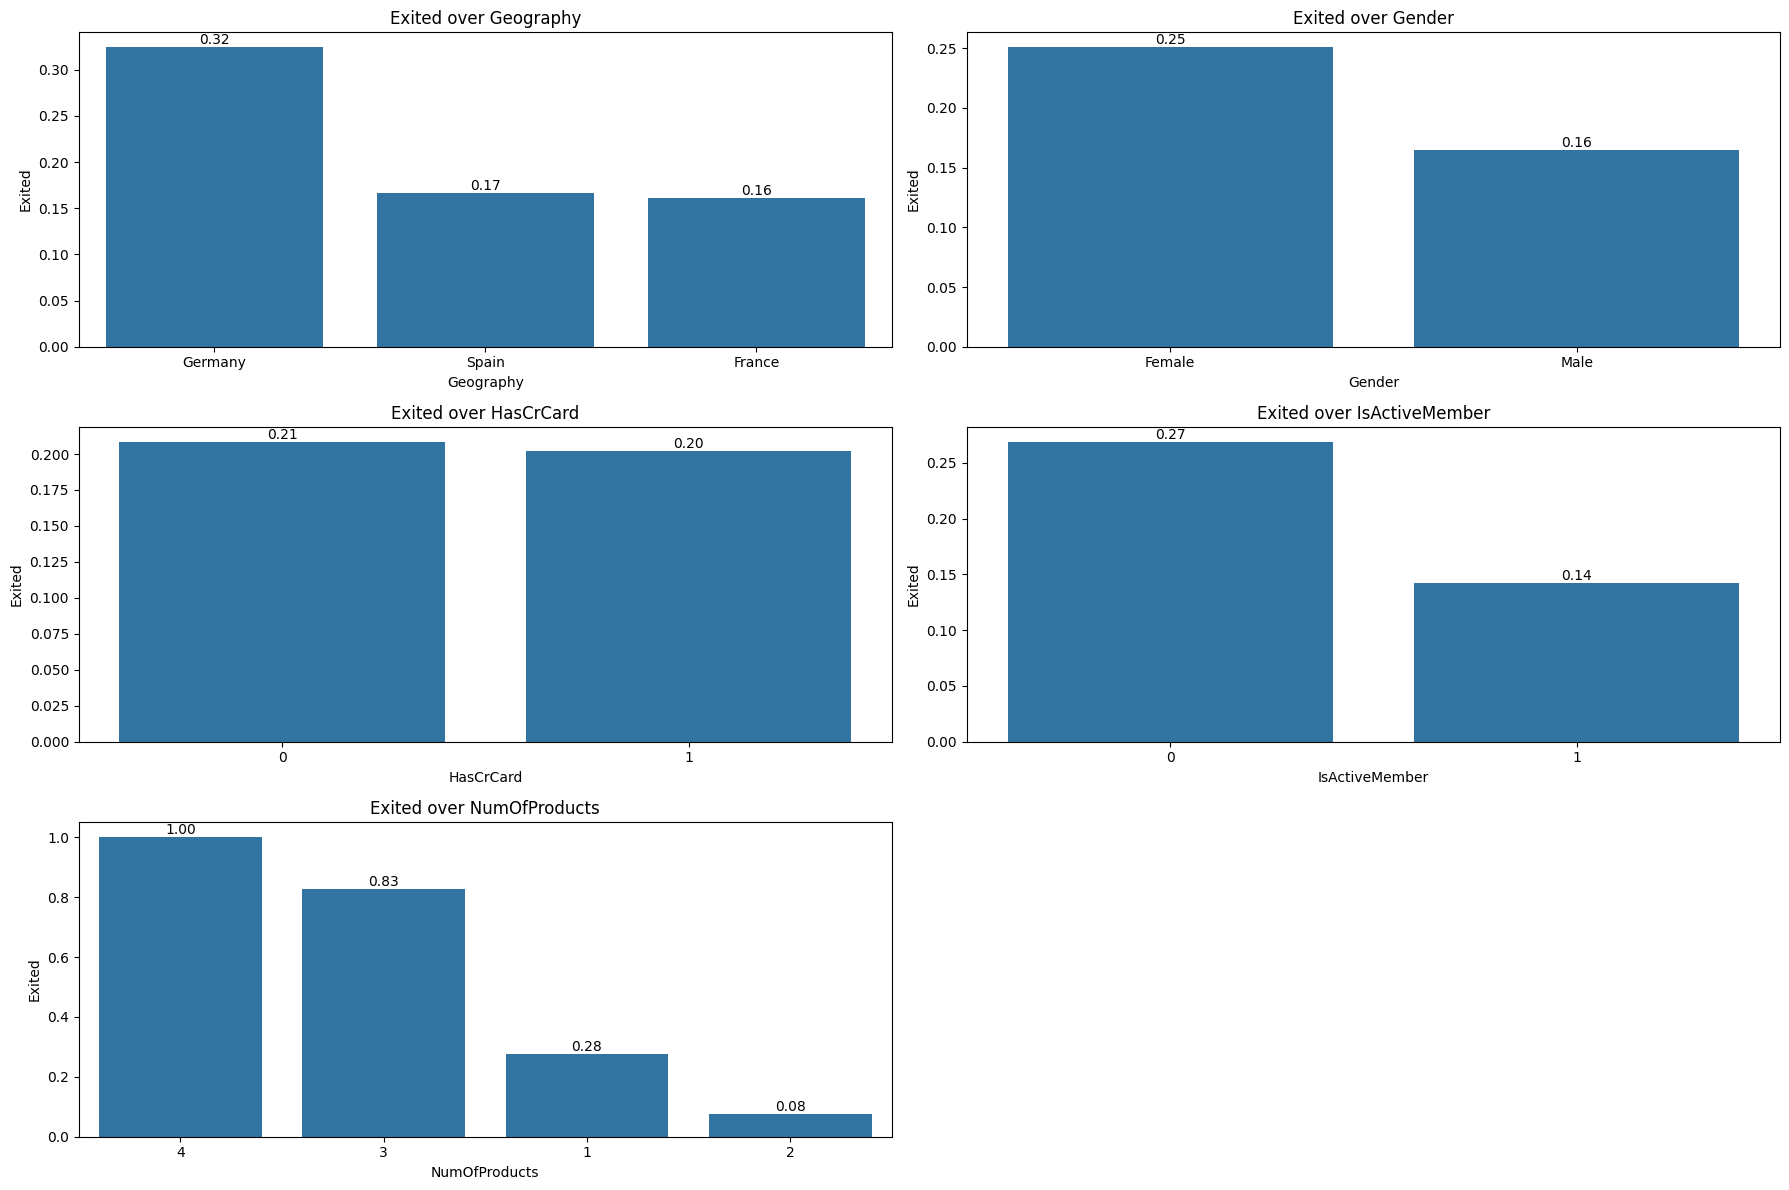

In [59]:
visualizer.cat_features_vs_target(3, 2, "Exited", cat_columns, "barplot")

### Observations:
- Around 32% of clients from Germany have churned. This is double the churn rate in relation to the other two countries and a sign for concern. It would be useful to generate a study highlighting the differences in products, treatment and services offered by France and Spain and compare them to what is being done in Germany
- Women left the institution more than men. It would be interesting to study the potential to create a campaign or product that not only attracts, but keeps women on the institution
- Despite 70% of all clients having a credit card, the churn rate of them is almost the same as clients that don't have a card. This can be an indicative that this feature is not very useful for the model
- Inactive members have a churn rate of almost double of the active ones. This suggests that the institution needs to keep the clients always active
- 2 products is the absolute ideal number for clients to have, since almost no client with 2 products decides to leave the institution. Clients with 3 or more product have an extremely high churn rate, but there are few clients in this zone. Another big issue is that there are a lot of clients with only 1 product, but the churn rat for them is relatively high, indicating that this is a group that requires attention from the institution
### Impact:
- `HasCrCard` needs to be further investigated to decide if it will be dropped or not

# Multivariable Analysis

## Geography x Numericals

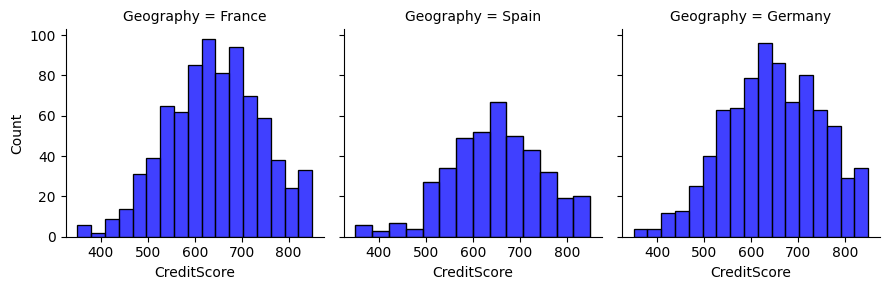

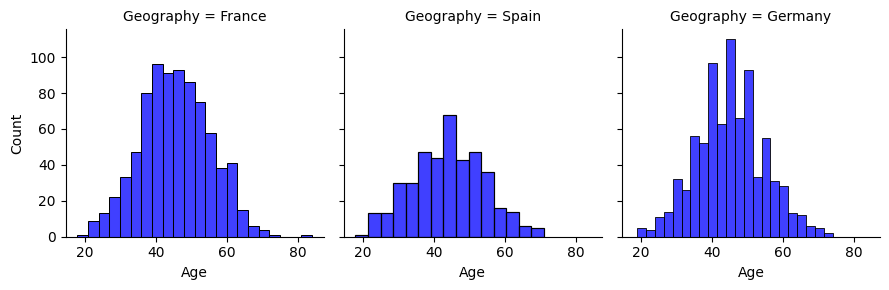

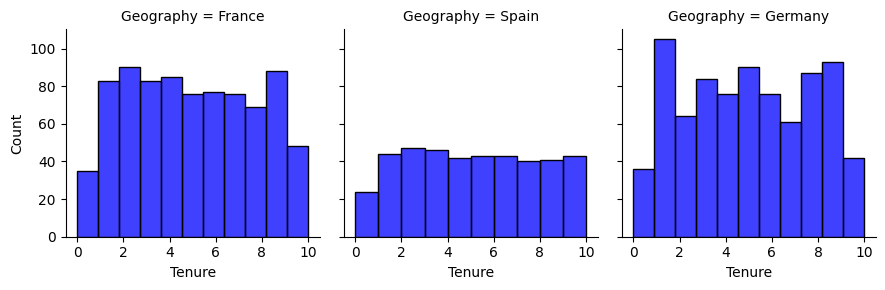

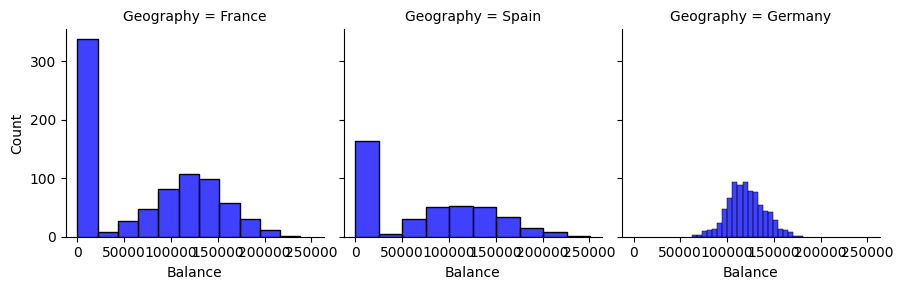

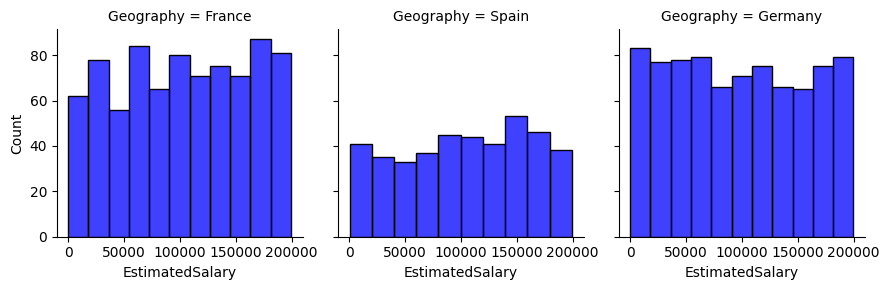

In [66]:
visualizer.facegrid_hist_target(facecol="Geography", color="blue", cols=numerical_columns, target="Exited")

## Gender x Numericals

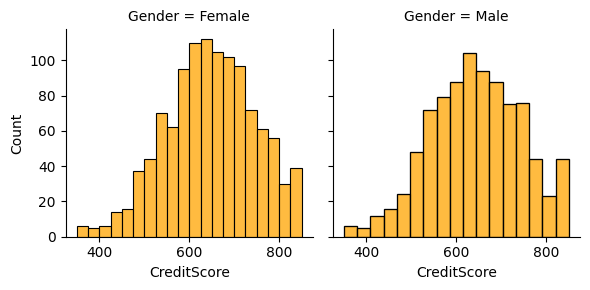

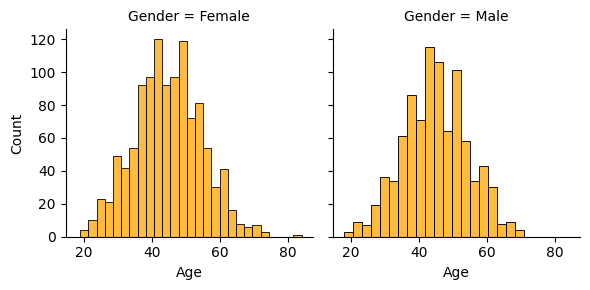

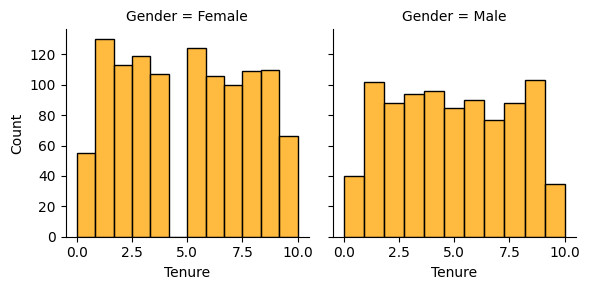

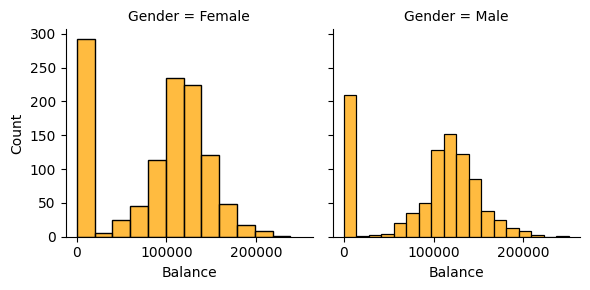

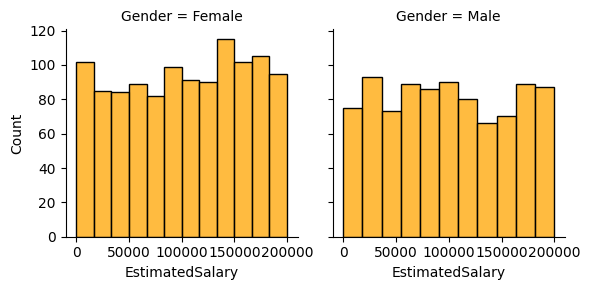

In [79]:
visualizer.facegrid_hist_target(facecol="Gender", color="orange", cols=numerical_columns, target="Exited")

## HasCrCard x Numericals

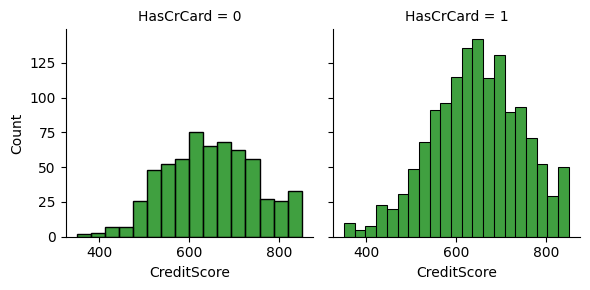

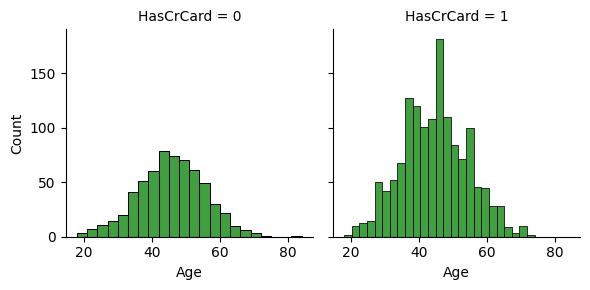

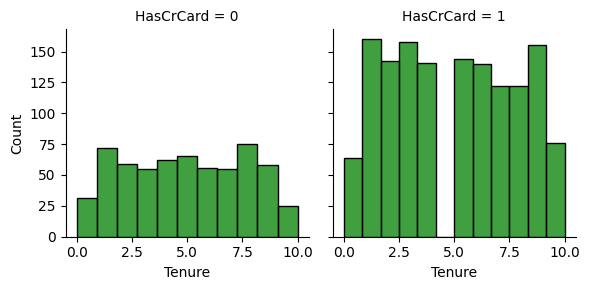

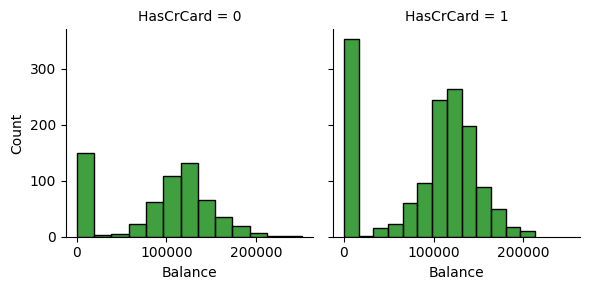

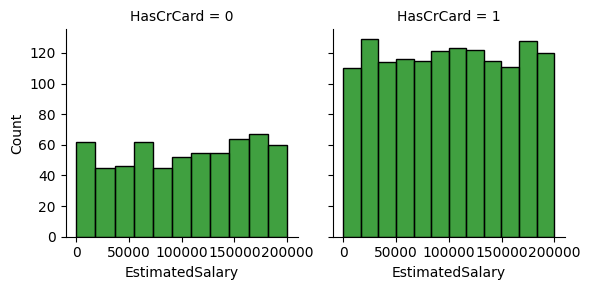

In [78]:
visualizer.facegrid_hist_target(facecol="HasCrCard", color="green", cols=numerical_columns, target="Exited")

## IsActiveMember x Numericals

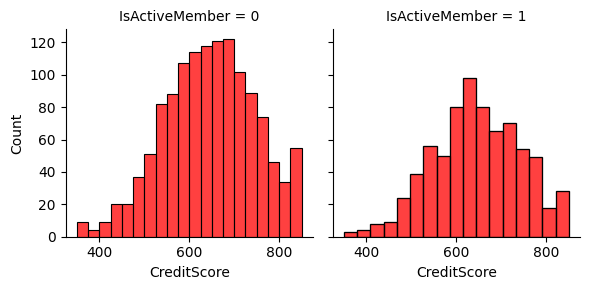

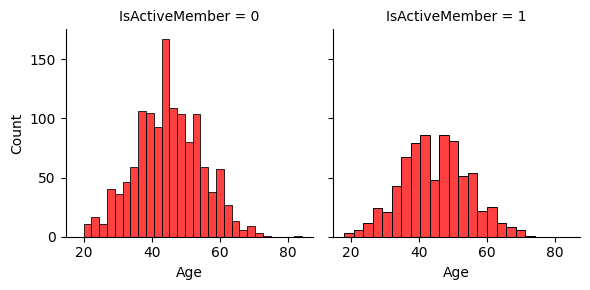

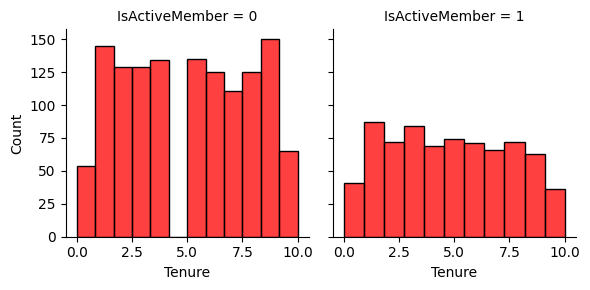

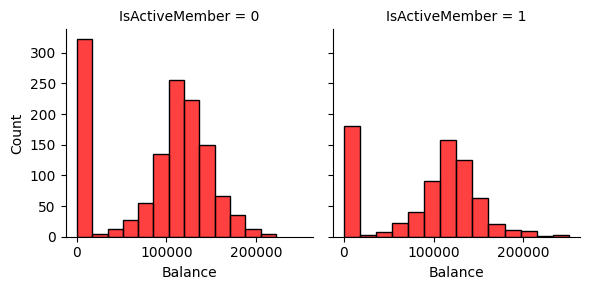

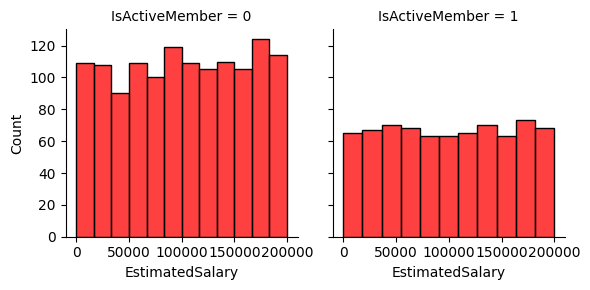

In [80]:
visualizer.facegrid_hist_target(facecol="IsActiveMember", color="red", cols=numerical_columns, target="Exited")

## NumOfProducts x Numericals

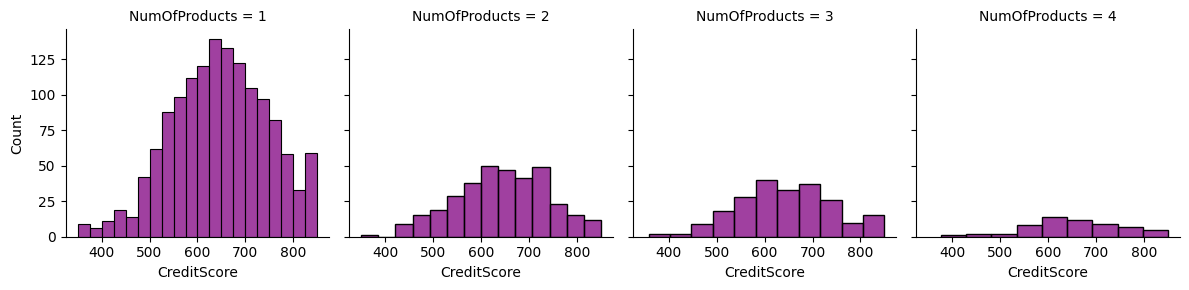

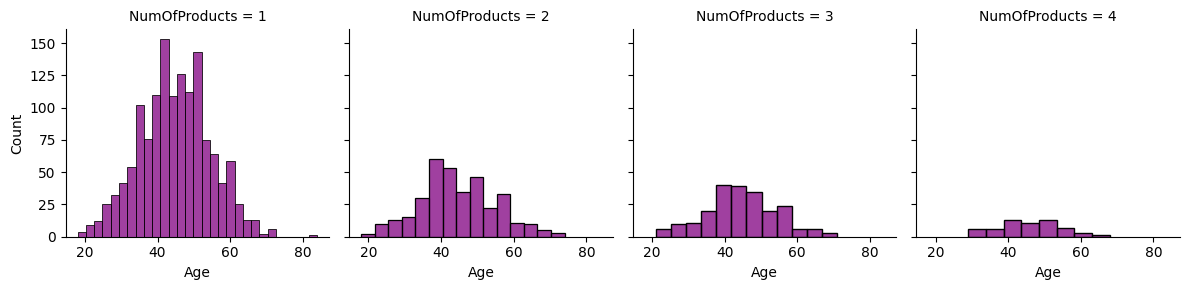

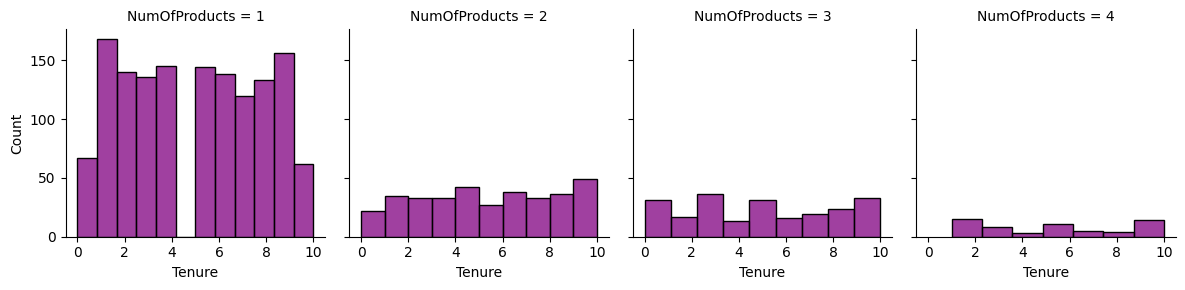

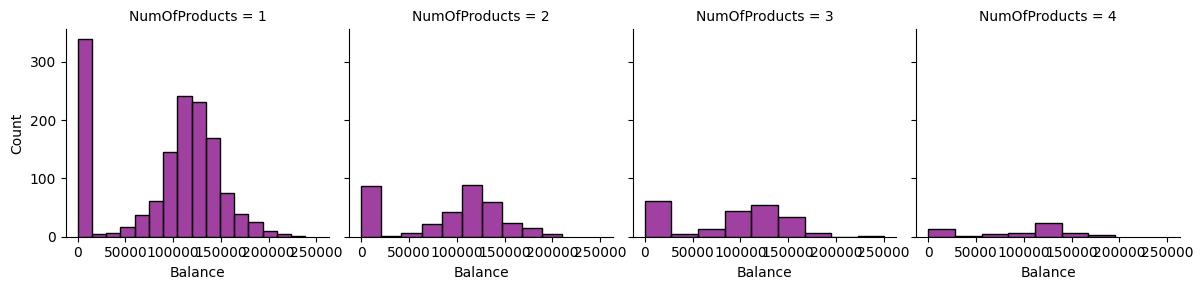

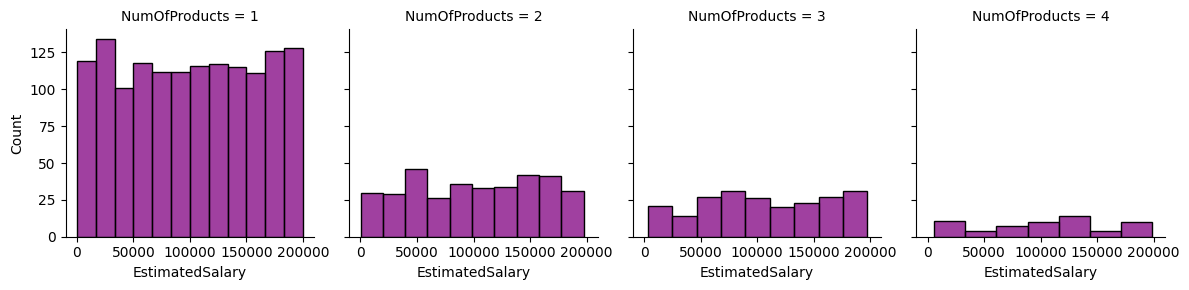

In [81]:
visualizer.facegrid_hist_target(facecol="NumOfProducts", color="purple", cols=numerical_columns, target="Exited")

### Observations:
- `Geography` shows an interesting behavior with `Balance` in relation to the target. Clients from Germany that churn, all have a balance above zero
- `HasCrCard` shows a massive spike of churns for clients that have credit cards and are around 45-47 years old. Since this is a huge spike of churns in relation to all other ages, this feature will not be dropped
- When a client is not as active member and is around 43-44 years old, there's a spike on the amount of churns, but on that same age interval for active clients, the amount of churns is way below what was seen and expected
- All other columns did not show any kind of special or strange behavior regarding the numerical features and how they behave themselves regarding the target

## Numericals x Numericals

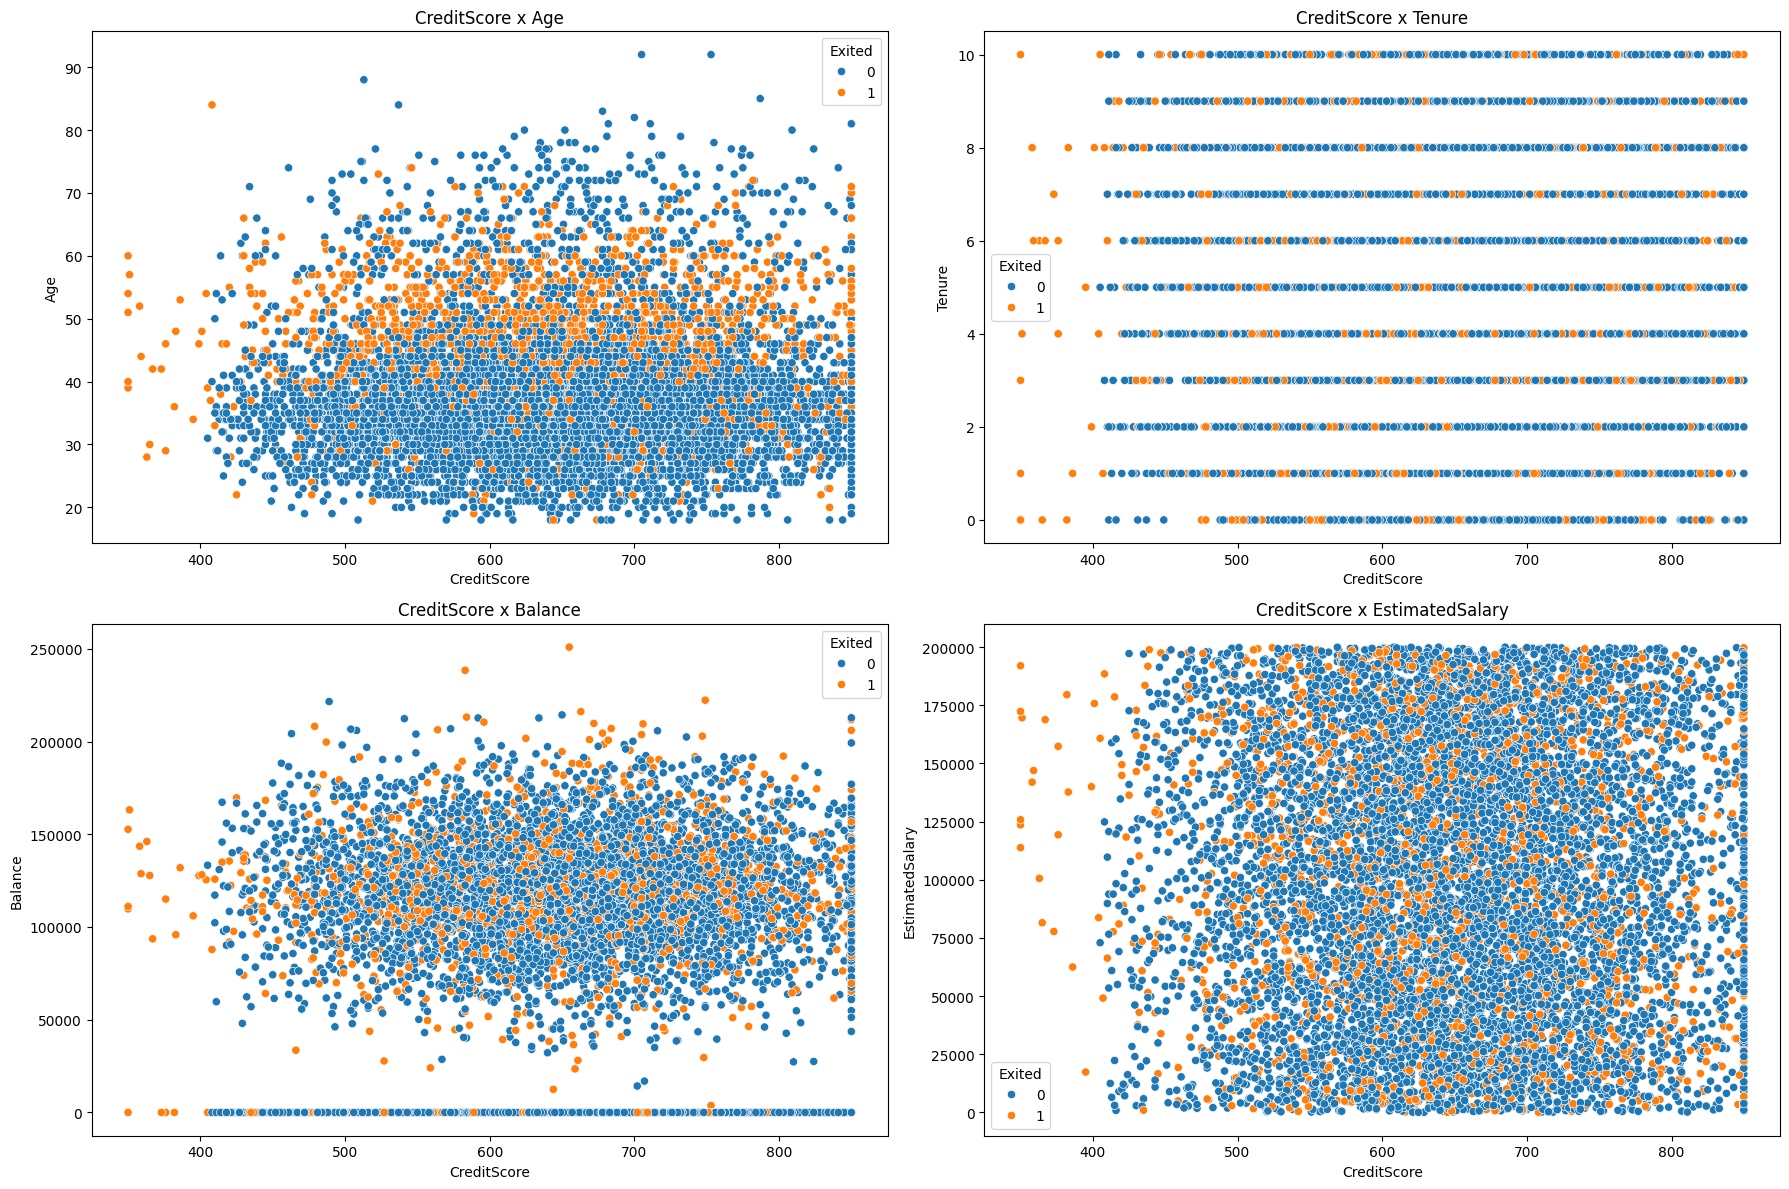

In [65]:
visualizer.scatter_numericals_target(2, 2, numerical_columns, "Exited", "CreditScore")

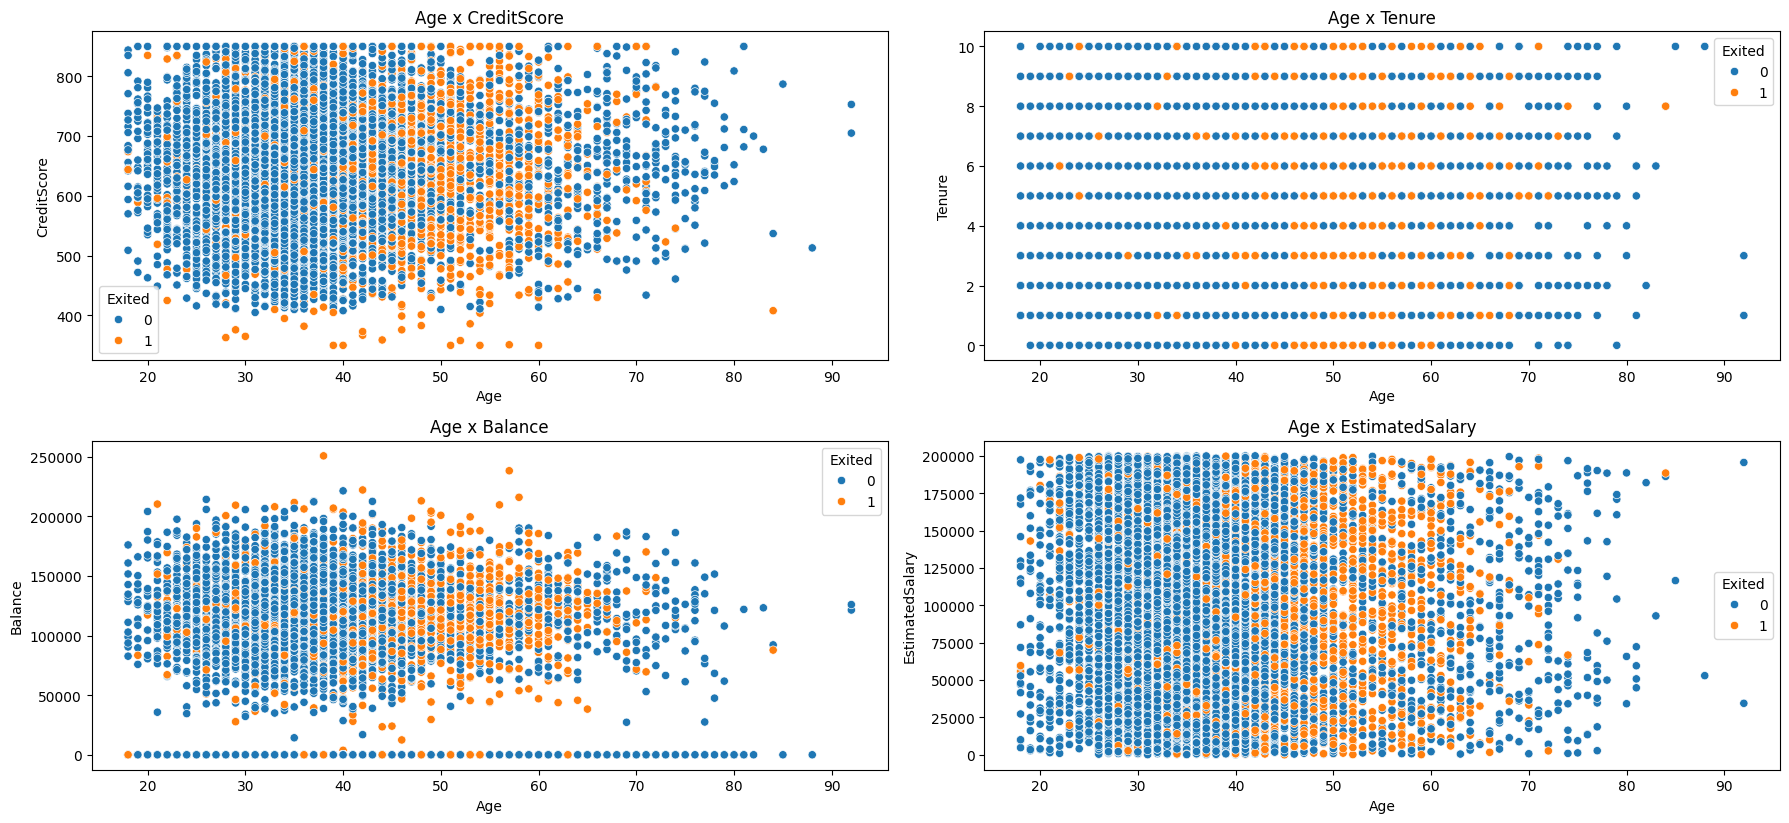

In [67]:
visualizer.scatter_numericals_target(3, 2, numerical_columns, "Exited", "Age")

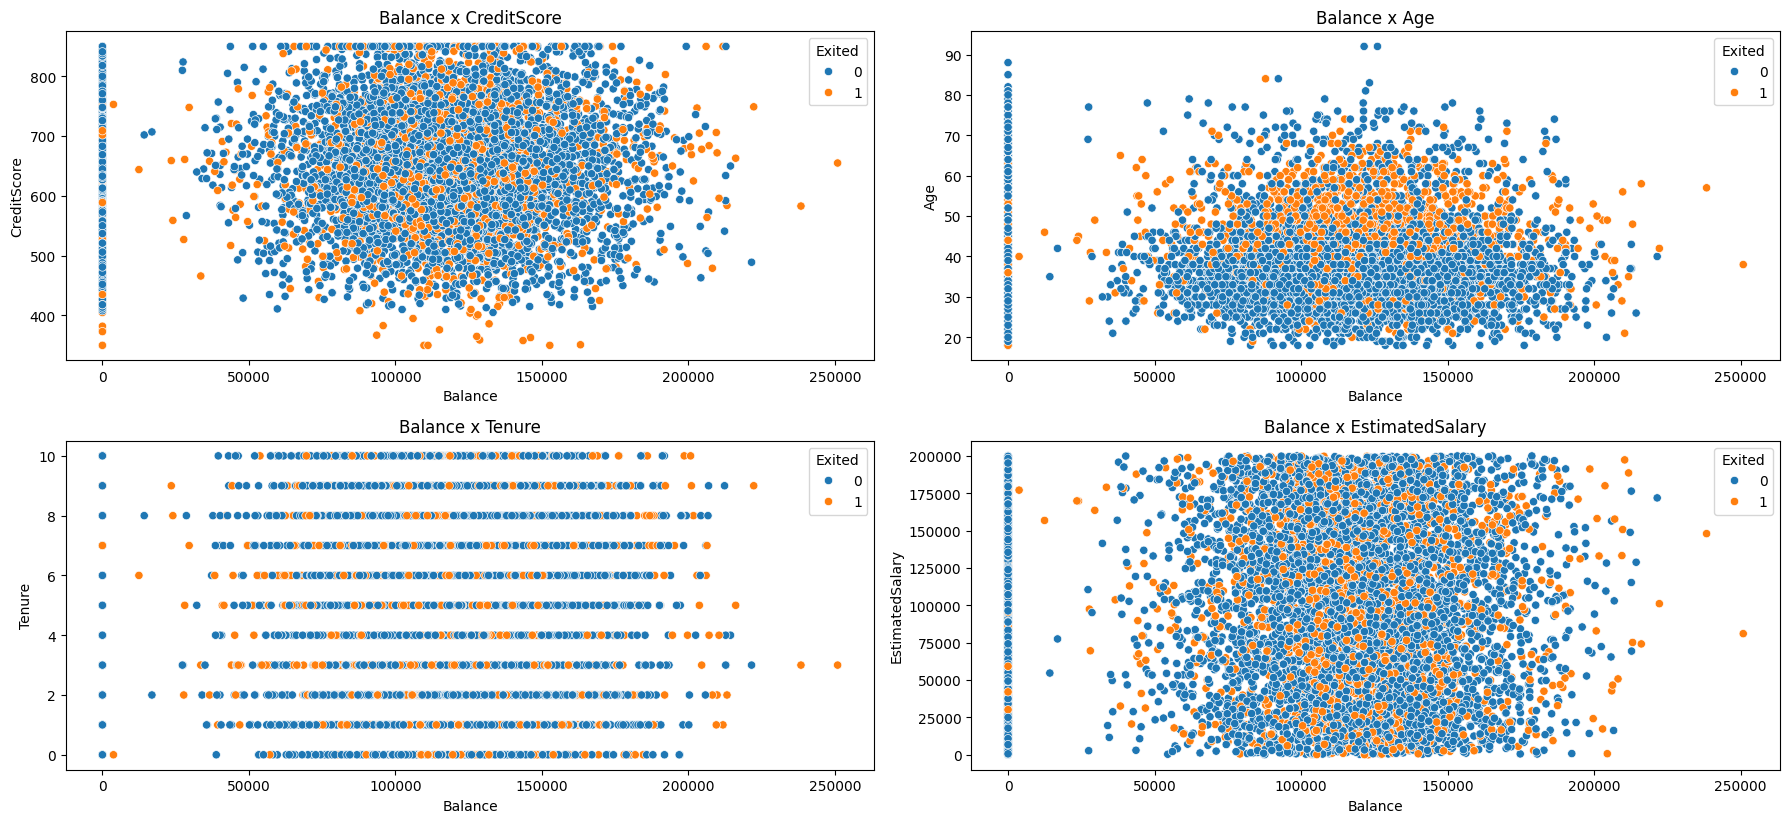

In [68]:
visualizer.scatter_numericals_target(3, 2, numerical_columns, "Exited", "Balance")

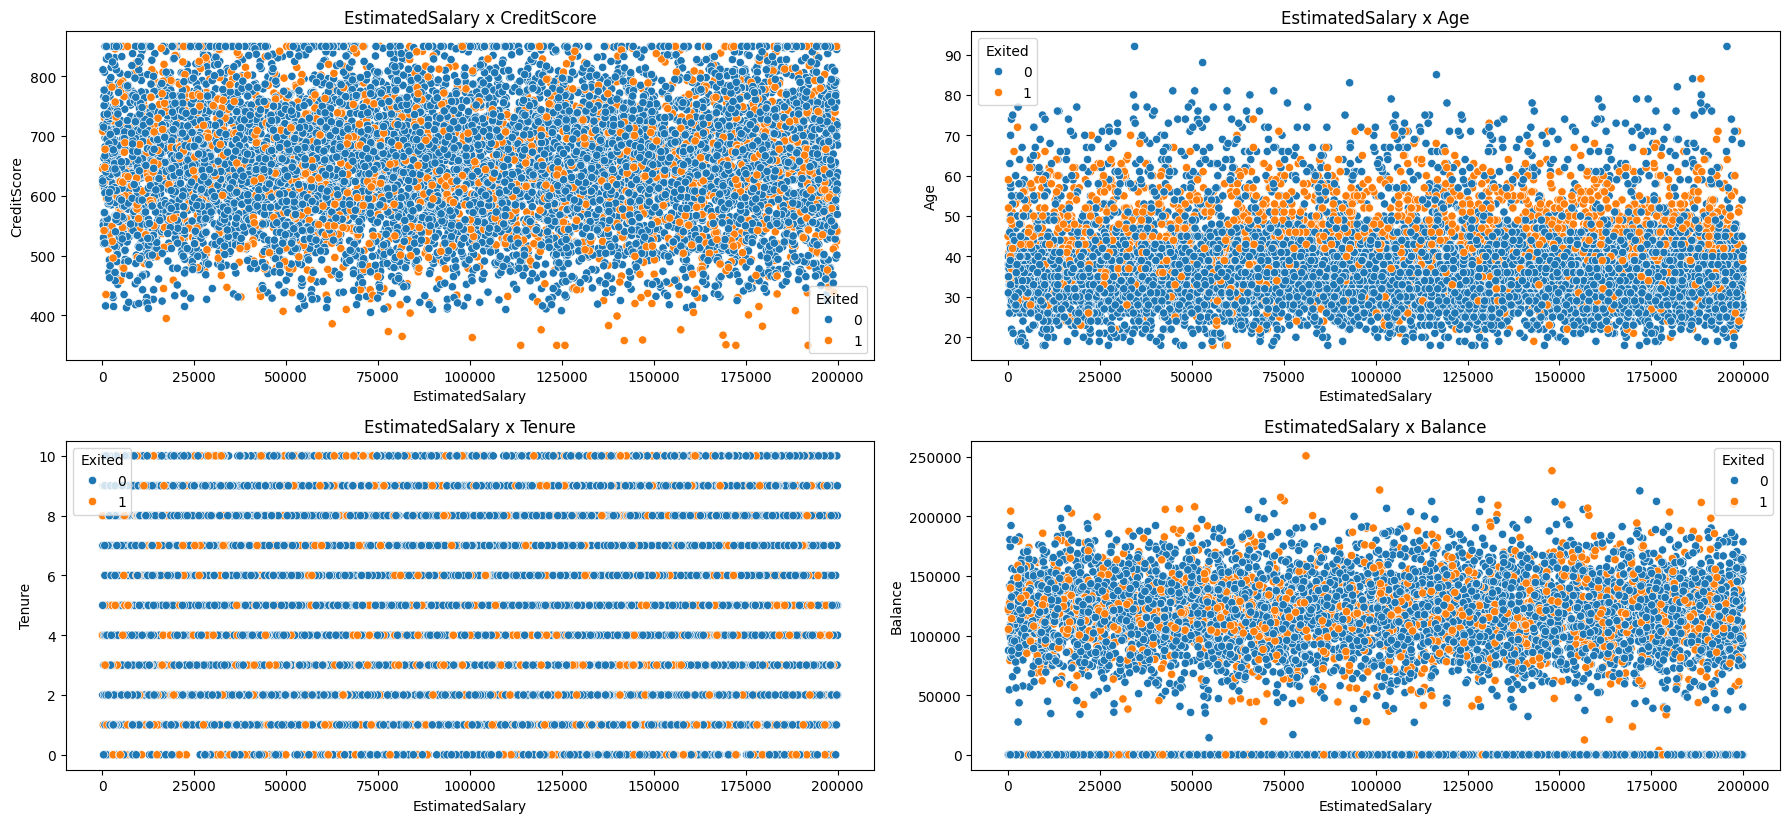

In [69]:
visualizer.scatter_numericals_target(3, 2, numerical_columns, "Exited", "EstimatedSalary")

### Observations:
- There's no clear correlation between the numerical features

# Summary

### Main Insights:
- `Exited` is very unbalanced, with almost 80% of all data concentrated on the 0 class
- `Balance` has a negatively skewed distribution, with mean < median < mode. Also, 36% of its values are 0, and out of all clients with no balance, 13% of them have churned
- `NumOfProducts` is extremely unbalanced and the churn rate per value is non-linear. 1 and 2 products compose 95% of `NumOfProducts` data
- `CreditScore`, `Tenure` and `EstimatedSalary` show the same behavior in relation to the target for all values and when plotted with all categorical features
- `Age` shows that older clients, around 40-50 years old, have a higher churn rate. This feature appears to be very useful for the model
- Around 32% of clients from Germany have churned. This is double the churn rate in relation to the other two countries
- Inactive members have a churn rate of almost double of the active ones
- 2 products is the absolute ideal number for clients to have, since almost no client with 2 products decides to leave the institution. Clients with 3 or more product have an extremely high churn rate, but there are few clients in this zone. Another big issue is that there are a lot of clients with only 1 product, but the churn rat for them is relatively high
- `Geography` shows an interesting behavior with `Balance` in relation to the target. Clients from Germany that churn, all have a balance above zero
### Implications for Feature Engineering and Modelling
- Class balancing methods needs to be used
- Scaling the data will be necessary for better results, but the scaler will be chosen after the columns are close to a gaussian distribution
- `NumOfProducts` will be used as a categorical feature. The values have a natural order, but they don't have a consistent relation with the target. Also, since all clients with 4 products have churned, the percentage for 3 products is very high and there are very few clients with 3 and 4 products, this can create a small bias to the model. To mitigate this, I will combine 3 and 4 products into the same category "3 or more", reducing the potential bias from the perfect correlation of 4 products - 100% chance of churn
- Two training datasets will be created, one will have `CreditScore`, `Tenure` and `EstimatedSalary` and the other won't. This way, the relevance of the features for the models will be measured and compared